<h1 align = 'center'> Data Modeling Using MCMC </h1>

In this notebook, the tutorial of data modeling is presented. At first a random dataset was generated. Then a model of straight line was fitted to the data. Then using Nelder-Mead algorithm the fitted parameters were optimized. Then using Markov Chain Monte Carlo (MCMC) the uncertainty level in the optimized values were determined.  

#### Importing Packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import emcee
import corner

#### Random Dataset

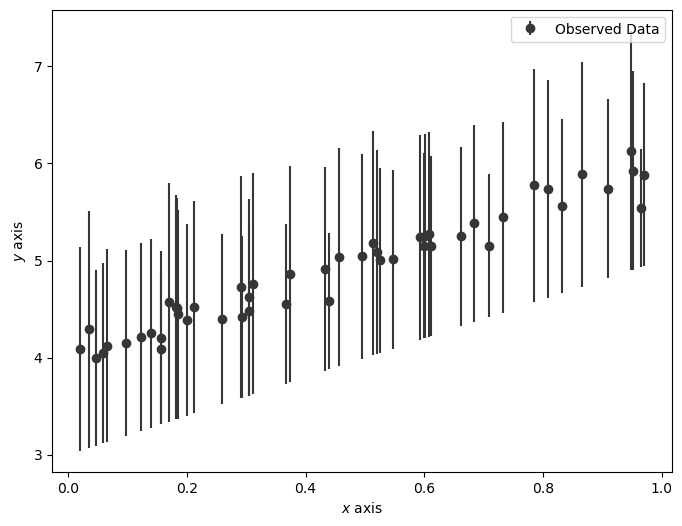

In [4]:
# generating
np.random.seed(42)
slope_real = 2
intercept_real = 3
x_real = np.random.random(50)
y_real = slope_real * x_real + intercept_real
y_err_real = np.random.normal(1, 0.15, len(x_real))
y_obs = y_real + y_err_real

# plotting
plt.figure(figsize=(8, 6))
plt.errorbar(x_real, y_obs, yerr=y_err_real, fmt='o', color='#363636', label='Observed Data')
plt.xlabel('$x$ axis')
plt.ylabel('$y$ axis')
plt.legend()
plt.show()

#### Modeling the Data

In [5]:
# a straight line model was fitted to the data
# y = mx + c

def model(x, m, c):
    return m * x + c

#### Optimization

In [6]:
# negative log-likelihood

def neg_log_likelihood(params, x, y, y_err):
    m, c = params
    y_model = model(x, m, c)
    return 0.5 * np.sum(((y - y_model) / y_err) ** 2)

In [7]:
# guess = [slope, intercept]
initial_guess = [2.5, 3.3]

# Nelder-Mead
result = minimize(neg_log_likelihood, initial_guess, args=(x_real, y_obs, y_err_real), method='Nelder-Mead')
optimized_params = result.x
print(f"Optimized parameters: Slope = {optimized_params[0]:.2f}, Intercept = {optimized_params[1]:.2f}")


Optimized parameters: Slope = 1.90, Intercept = 4.00


#### MCMC

In [8]:
# bounds
bounds = [(0, 5),  # slope
          (0, 10)]  # intercept

# log-prob
def log_probability(params, x, y, y_err, bounds):
    m, c = params
    slope_bounds, intercept_bounds = bounds
    if not (slope_bounds[0] < m < slope_bounds[1] and intercept_bounds[0] < c < intercept_bounds[1]):
        return -np.inf
    return -neg_log_likelihood(params, x, y, y_err)


In [9]:
# init walkers
n_walkers = 32
n_steps = 10000
initial_pos = optimized_params + 1e-4 * np.random.randn(n_walkers, len(optimized_params))

# sampling
sampler = emcee.EnsembleSampler(
    n_walkers,
    len(optimized_params),
    log_probability,
    args=(x_real, y_obs, y_err_real, bounds)
)
sampler.run_mcmc(initial_pos, n_steps, progress=True)

100%|██████████| 10000/10000 [00:06<00:00, 1487.69it/s]


State([[1.71850769 4.10028199]
 [1.43559153 4.07602133]
 [2.59883995 3.84260272]
 [1.28352148 4.43080187]
 [1.18017833 4.37103041]
 [2.41713225 3.64736528]
 [2.46535613 3.67789702]
 [1.89618267 3.97572108]
 [2.80988107 3.55468958]
 [1.14216162 4.57234475]
 [1.98205484 4.11380024]
 [2.34262357 3.63215441]
 [2.48260516 3.87406791]
 [2.20653219 3.76708497]
 [2.40336214 3.64326846]
 [1.95413235 3.89882708]
 [2.17313803 3.92580033]
 [1.73690319 4.33339575]
 [1.24555318 4.31714255]
 [1.9698307  4.14703094]
 [1.94858117 3.91328899]
 [1.89069216 3.88374753]
 [2.58736351 3.95621259]
 [2.31051912 3.73376761]
 [1.98249508 3.90166093]
 [2.44474846 3.79565566]
 [1.55052912 4.14385087]
 [1.79448398 4.160947  ]
 [1.74915312 3.88703026]
 [1.00925958 4.59612193]
 [2.23088179 3.66755302]
 [1.56163675 4.17574736]], log_prob=[-0.66569645 -1.58902673 -2.39773043 -2.02371721 -1.80578516 -1.54456507
 -1.41064354 -0.60226215 -2.47664249 -3.22210426 -1.20422385 -1.75461591
 -1.88147741 -1.02458013 -1.58025566 

#### Corner Plot

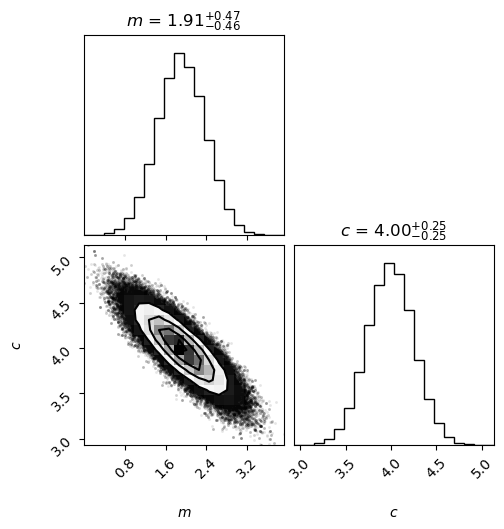

In [10]:
param_names = ["$m$", "$c$"]

fig = corner.corner(
    sampler.get_chain(flat=True),  # Flatten the chain for corner
    labels=param_names,
    show_titles=True,
    title_fmt=".2f",  # Format for titles
    title_quantiles=[0.16, 0.5, 0.84]  # Show median and 1-sigma intervals
)

plt.show()